# InSituPy demonstration - Performance tests

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import read_xenium
from datetime import datetime
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
import geopandas as gpd
import shapely

## Load Xenium data into `InSituData` object

In [4]:
insitupy_project = Path("../demo_dataset/demo_insitupy_project")

In [5]:
xd = read_xenium(insitupy_project)

In [6]:
xd.load_cells()
xd.load_images()

Loading cells...
	No alternative cells found...
Loading images...


In [7]:
xd.show()

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


In [9]:
pixel_size = xd.images.metadata["nuclei"]["pixel_size"]
pl = xd.viewer.layers["Points"]
#ll = xd.viewer.layers["Shapes"]
px = pl.data[:, 1] * pixel_size
py = pl.data[:, 0] * pixel_size
points = gpd.points_from_xy(px, py)

In [10]:
x = xd.cells.matrix.obsm["spatial"][:, 0]
y = xd.cells.matrix.obsm["spatial"][:, 1]

In [11]:
cells = gpd.points_from_xy(x, y)

In [12]:
# measure distance of all cells to one point
dists = np.array([cells.distance(p) for p in points])

In [13]:
dists

array([[2350.24854787, 2356.48709125, 2344.53735655, ..., 6307.48211482,
        6318.35235446, 6326.65703662],
       [2823.53684718, 2828.60233868, 2817.79546321, ..., 6094.39399644,
        6104.8342925 , 6113.826066  ],
       [3104.41209558, 3114.68709374, 3098.97232046, ..., 5362.85859638,
        5373.73008901, 5382.03314382],
       [4811.22297331, 4831.19331898, 4808.50696362, ..., 4183.84879916,
        4195.84879497, 4196.3699068 ]])

In [14]:
points

<GeometryArray>
[<POINT (1730.225 2504.273)>, <POINT (1756.285 2999.398)>,
 <POINT (2590.179 2895.161)>,  <POINT (5534.87 1409.786)>]
Length: 4, dtype: geometry

In [15]:
from skmisc.loess import loess

In [16]:
min_dists = dists.min(axis=0)

In [17]:
min_dists

array([2350.24854787, 2356.48709125, 2344.53735655, ..., 4183.84879916,
       4195.84879497, 4196.3699068 ])

In [18]:
xd.cells.matrix.obs["dist_from_points"] = min_dists

In [19]:
from insitupy.plotting.expression_along_axis import expr_along_obs_val

In [27]:
data = expr_along_obs_val(adata=xd.cells.matrix,
                   keys="ACTA2",
                   x_category="dist_from_points", groupby=None, return_data=True,
                   stderr=False, nsteps=10
                   )

In [57]:
data.dropna(how="all", axis=1)

x    y_pred    std
key                                       
ACTA2 None 0   504.257656  1.877883  False
           1  1004.245360  1.951516  False
           2  1504.233064  1.936031  False
           3  2004.220768  1.881070  False
           4  2504.208473  1.756132  False
           5  3004.196177  1.817721  False
           6  3504.183881  2.123669  False
           7  4004.171585  2.658033  False

In [58]:
data

x    y_pred    std  conf_lower  conf_upper
key                                                               
ACTA2 None 0   504.257656  1.877883  False         NaN         NaN
           1  1004.245360  1.951516  False         NaN         NaN
           2  1504.233064  1.936031  False         NaN         NaN
           3  2004.220768  1.881070  False         NaN         NaN
           4  2504.208473  1.756132  False         NaN         NaN
           5  3004.196177  1.817721  False         NaN         NaN
           6  3504.183881  2.123669  False         NaN         NaN
           7  4004.171585  2.658033  False         NaN         NaN

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


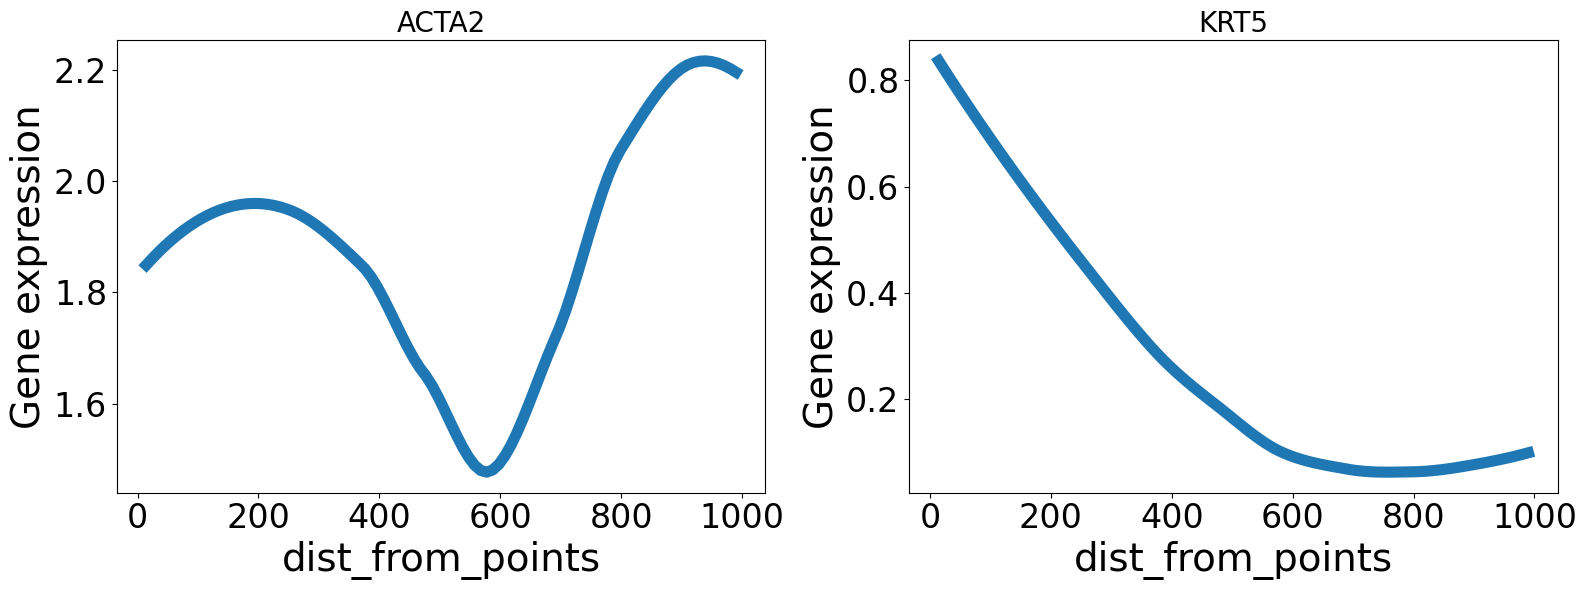

In [65]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=["ACTA2", "KRT5"],
                   x_category="dist_from_points", groupby=None, return_data=False,
                   stderr=False, nsteps=100, plot_legend=False, xmax=1000
                   )

<Axes: xlabel='x'>

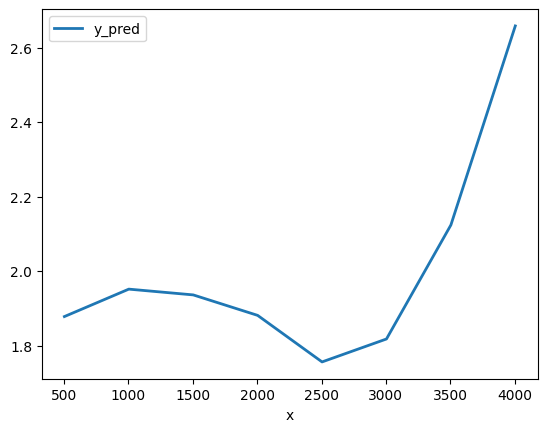

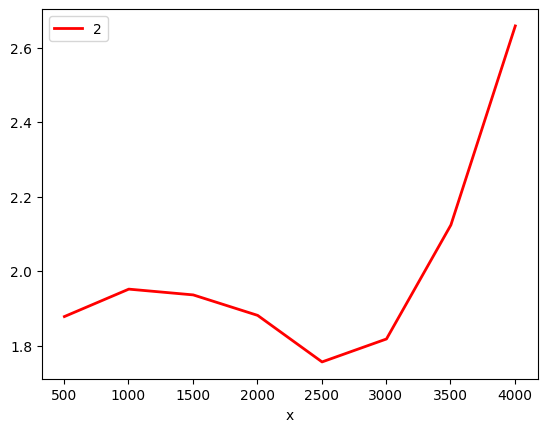

In [41]:
data.plot(kind="line", x="x", y="y_pred", label=None, color=None, linewidth=2)
data.plot(kind="line", x="x", y="y_pred", label="2", color="red", linewidth=2)

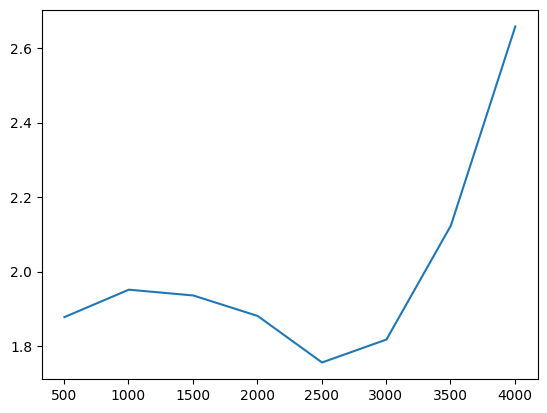

In [32]:
plt.plot(data["x"], data["y_pred"])

In [30]:
data.columns

Index(['x', 'y_pred', 'std', 'conf_lower', 'conf_upper'], dtype='object')

In [23]:
data

x    y_pred    std  conf_lower  conf_upper
key                                                               
ACTA2 None 0   504.257656  1.877883  False         NaN         NaN
           1  1004.245360  1.951516  False         NaN         NaN
           2  1504.233064  1.936031  False         NaN         NaN
           3  2004.220768  1.881070  False         NaN         NaN
           4  2504.208473  1.756132  False         NaN         NaN
           5  3004.196177  1.817721  False         NaN         NaN
           6  3504.183881  2.123669  False         NaN         NaN
           7  4004.171585  2.658033  False         NaN         NaN

In [27]:
ls, xs_pred = data

In [30]:
pred =  ls.predict(xs_pred, stderror=False)

: 

In [29]:
pred.stderr

ValueError: Standard error was not computed.Use 'stderror=True' when predicting.

In [24]:
data.stderr

ValueError: Standard error was not computed.Use 'stderror=True' when predicting.

In [23]:
data

x    y_pred    std  conf_lower  conf_upper
key                                                               
ACTA2 None 0   479.806029  2.100595  False         NaN         NaN
           1   958.483608  1.943201  False         NaN         NaN
           2  1437.161187  1.921318  False         NaN         NaN
           3  1915.838766  1.826385  False         NaN         NaN
           4  2394.516345  1.634902  False         NaN         NaN
           5  2873.193924  1.797144  False         NaN         NaN
           6  3351.871503  2.273278  False         NaN         NaN
           7  3830.549082  3.041486  False         NaN         NaN

In [33]:
xs

NameError: name 'xs' is not defined

ValueError: setting an array element with a sequence.

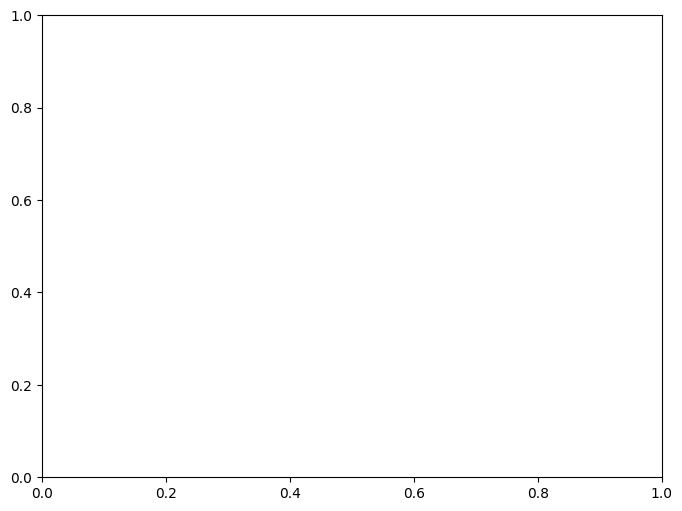

In [ ]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys="ACTA2",
                   x_category="dist_from_points", groupby=None
                   )

ValueError: setting an array element with a sequence.

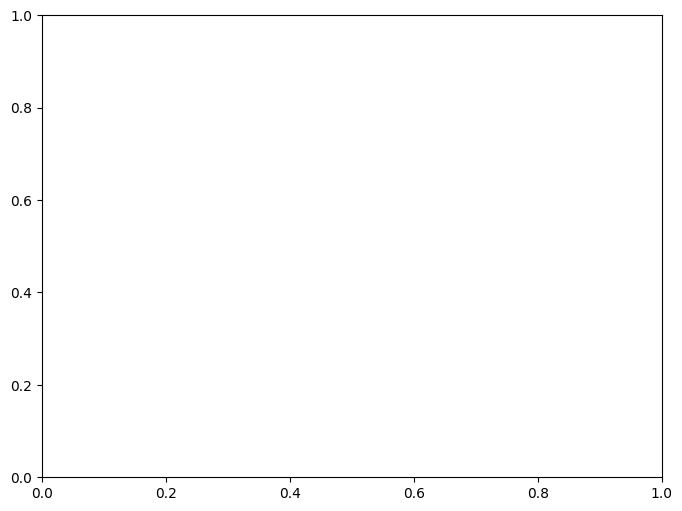

In [ ]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys="ACTA2",
                   x_category="dist_from_points", groupby=None
                   )

In [ ]:
a

In [19]:
dists.shape

(8, 167780)

In [13]:
points

<GeometryArray>
[<POINT (1910.078 2939.854)>, <POINT (2054.715 2852.311)>,
 <POINT (1872.015 2585.873)>, <POINT (1970.978 3210.098)>,
 <POINT (2225.996 3164.423)>,  <POINT (2069.94 3377.573)>,
  <POINT (2770.289 2974.11)>, <POINT (5278.293 1273.736)>]
Length: 8, dtype: geometry

In [12]:
dist.min()

10.316043603539608

In [91]:
dist

array([2840.97583443, 2847.16676686, 2835.26350056, ..., 5964.1267676 ,
       5974.66129396, 5983.51357957])

In [92]:
from shapely import LineString

In [93]:
ll.data[0]

array([[ 7264.325411  , 28308.07095047],
       [ 7743.80240649, 27436.29459505],
       [ 9182.23339293, 26491.87021001],
       [10577.0755616 , 24922.67277026],
       [11812.09206511, 23992.77799114],
       [13250.52305156, 23760.30429636]])

In [94]:
line_coords_xy = np.flip(ll.data[0], axis=1) * pixel_size

In [95]:
line = LineString(line_coords_xy)

In [96]:
cells.distance(line)

array([4779.33797023, 4797.11646734, 4775.46252531, ..., 3341.75590766,
       3353.85023477, 3358.49688704])

In [97]:
xd.cells.matrix.obs["line"] = cells.distance(line)
xd.cells.matrix.obs["line2"] = cells.distance(line)**2

In [82]:
xd.show()

In [99]:
adata = xd.cells.matrix

In [100]:
adata

AnnData object with n_obs × n_vars = 167780 × 313
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'annotation-demo', 'annotation-demo2', 'line', 'line2'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'
    varm: 'binned_expression'

In [102]:
adata.X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [4., 1., 5., ..., 0., 0., 3.],
       [1., 0., 0., ..., 0., 0., 0.],
       [4., 1., 3., ..., 0., 0., 0.]], dtype=float32)

In [103]:
adata.obs

,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area,annotation-demo,annotation-demo2,line,line2
1,28,1,0,29,58.387031,26.642188,NaN,NaN,4779.337970,2.284207e+07
2,94,0,0,94,197.016719,42.130781,NaN,NaN,4797.116467,2.301233e+07
3,9,0,0,9,16.256250,12.688906,NaN,NaN,4775.462525,2.280504e+07
4,11,0,0,11,42.311406,10.069844,NaN,NaN,4796.173524,2.300328e+07
5,48,0,0,48,107.652500,37.479688,NaN,NaN,4781.829921,2.286590e+07
...,...,...,...,...,...,...,...,...,...,...
167776,229,1,0,230,220.452813,60.599688,NaN,NaN,3328.190758,1.107685e+07
167777,79,0,0,79,37.389375,25.242344,NaN,NaN,3346.342668,1.119801e+07
167778,397,0,0,397,287.058281,86.700000,NaN,NaN,3341.755908,1.116733e+07
167779,117,0,0,117,235.354375,25.197188,NaN,NaN,3353.850235,1.124831e+07


In [104]:
adata.var

,gene_ids,feature_types,genome
ABCC11,ENSG00000121270,Gene Expression,Unknown
ACTA2,ENSG00000107796,Gene Expression,Unknown
ACTG2,ENSG00000163017,Gene Expression,Unknown
ADAM9,ENSG00000168615,Gene Expression,Unknown
ADGRE5,ENSG00000123146,Gene Expression,Unknown
...,...,...,...
VWF,ENSG00000110799,Gene Expression,Unknown
WARS,ENSG00000140105,Gene Expression,Unknown
ZEB1,ENSG00000148516,Gene Expression,Unknown
ZEB2,ENSG00000169554,Gene Expression,Unknown


In [44]:
xd.store_annotations()

Added 1 new annotations to key 'test'


In [46]:
xd.annotations.test

,objectType,geometry,name,color,origin
id,,,,,
5af017cc-02a8-4644-8687-7f07f4591693,annotation,"POLYGON ((6021.63193 1559.75951, 5801.00825 16...",blubb,"[255, 0, 0]",manual


In [47]:
xd.show()

In [42]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 167780 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'annotation-demo', 'annotation-demo2'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear

In [62]:
l = xd.viewer.layers["Shapes"]
l2 = xd.viewer.layers["*blubb (test)"]
p = xd.viewer.layers["Points"]

In [56]:
l.shape_type

['path']

In [58]:
l2.shape_type

['polygon', 'polygon', 'path']

In [60]:
type(l2)

napari.layers.shapes.shapes.Shapes

In [61]:
type(l)

napari.layers.shapes.shapes.Shapes

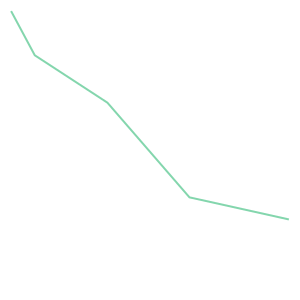

In [34]:
LineString(ll.data[0])

In [17]:
ll.data[0]

array([[ 7282.3753437 , 28338.57000552],
       [ 7817.66894886, 27339.35527589],
       [ 9459.23600467, 26268.76806558],
       [11314.92050255, 24127.59364495],
       [13563.15364421, 23627.98628013]])

In [22]:
ll.data[0][:, 0]

array([ 7282.3753437 ,  7817.66894886,  9459.23600467, 11314.92050255,
       13563.15364421])

In [24]:
s = gpd.points_from_xy(ll.data[0][:, 1], ll.data[0][:, 0])

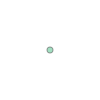

In [25]:
s[0]